In [1]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.7 MB/s eta 0:00:00


In [2]:

import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from torchvision import models, transforms
from tqdm import tqdm
from datasets import load_dataset
from typing import List
from collections import Counter
import math
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
def basic_tokenize(text: str) -> List[str]:
    text = text.lower().strip()
    # tách . , ! ? ; : () thành token riêng
    text = re.sub(r'([.,!?;:()])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.split()

class SimpleTokenizer:
    def __init__(self, vocab: List[str]):
        specials = ["<pad>", "<bos>", "<eos>", "<unk>"]
        vocab = specials + [w for w in vocab if w not in specials]
        self.stoi = {w: i for i, w in enumerate(vocab)}
        self.itos = {i: w for w, i in self.stoi.items()}
        self.pad_id = self.stoi["<pad>"]
        self.bos_id = self.stoi["<bos>"]
        self.eos_id = self.stoi["<eos>"]
        self.unk_id = self.stoi["<unk>"]

    def encode(self, text: str) -> List[int]:
        tokens = basic_tokenize(text)
        return [self.stoi.get(t, self.unk_id) for t in tokens]

    def decode(self, ids: List[int]) -> str:
        toks = []
        for i in ids:
            if i in (self.pad_id, self.bos_id, self.eos_id):
                continue
            toks.append(self.itos.get(i, "<unk>"))
        # nối rồi xử lý lại khoảng trắng trước dấu câu (cho đẹp)
        sent = " ".join(toks)
        sent = re.sub(r'\s+([.,!?;:])', r'\1', sent)
        return sent

def collect_rsicd_words(hf_train, hf_val, min_freq=3):
    cnt = Counter()
    for split in [hf_train, hf_val]:
        for ex in split:
            cap = ex["captions"]
            if isinstance(cap, list):
                for c in cap:
                    cnt.update(basic_tokenize(c))
            else:
                cnt.update(basic_tokenize(cap))
    words = [w for w, freq in cnt.most_common() if freq >= min_freq]
    return words

# Load dataset
ds = load_dataset("arampacha/rsicd")
rsicd_words = collect_rsicd_words(ds["train"], ds["valid"], min_freq=2)
print(f"RSICD unique words (freq >=2): {len(rsicd_words)}")

tokenizer = SimpleTokenizer(rsicd_words)
print(f"Final vocab size: {len(tokenizer.stoi)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

data/valid-00000-of-00001.parquet:   0%|          | 0.00/51.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8734 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1093 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1094 [00:00<?, ? examples/s]

RSICD unique words (freq >=3): 2215
Wordfreq not available, using RSICD only
Final vocab size: 2219


In [4]:
# ============================================================================
# TRANSFORMS - BỎ AUGMENTATION QUÁ MẠNH CHO TRAINING
# ============================================================================
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [5]:
class RSICDDataset(Dataset):
    def __init__(self, hf_split, tokenizer, transform=None, max_len=25, is_train=True, n_caps=5):
        self.data = hf_split
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len
        self.is_train = is_train
        self.n_caps = n_caps

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        ex = self.data[idx]

        # image
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))
        if self.transform is not None:
            image = self.transform(image)

        # captions: lấy đúng 5
        caps = ex["captions"]
        if isinstance(caps, str):
            caps = [caps]
        caps = [c.strip() for c in caps if isinstance(c, str) and c.strip()]
        caps = caps[:self.n_caps]
        assert len(caps) == self.n_caps

        return image, caps


def collate_fn(batch):
    images_expanded = []
    captions_ids = []
    all_caps_batch = []   # lưu 5 caption gốc/ảnh để SCST + eval

    for image, caps in batch:      # caps: list 5 câu
        all_caps_batch.append(caps)

        for c in caps:             # multi-caption unroll B*5
            images_expanded.append(image)

            ids = tokenizer.encode(c)
            ids = [tokenizer.bos_id] + ids + [tokenizer.eos_id]
            ids = ids[:max_len]
            pad_len = max_len - len(ids)
            if pad_len > 0:
                ids = ids + [tokenizer.pad_id] * pad_len
            captions_ids.append(torch.tensor(ids, dtype=torch.long))

    images_expanded = torch.stack(images_expanded, dim=0)   # [B*5, 3, H, W]
    captions_ids = torch.stack(captions_ids, dim=0)         # [B*5, max_len]

    return images_expanded, captions_ids, all_caps_batch


In [6]:
batch_size = 64
max_len = 25
n_caps = 5

train_data = RSICDDataset(ds["train"], tokenizer, transform=train_transform,
                          max_len=max_len, is_train=True, n_caps=n_caps)
val_data   = RSICDDataset(ds["valid"], tokenizer, transform=val_transform,
                          max_len=max_len, is_train=False, n_caps=n_caps)
test_data  = RSICDDataset(ds["test"],  tokenizer, transform=val_transform,
                          max_len=max_len, is_train=False, n_caps=n_caps)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_data,   batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True, collate_fn=collate_fn)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 8734, Val: 1094, Test: 1093


In [7]:
class ResNetEncoder(nn.Module):
    def __init__(self, output_dim=512, dropout_p=0.5):
        super().__init__()
        base_model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)

        # Freeze early layers
        for param in list(base_model.parameters())[:-30]:  # freeze trừ 30 layers cuối
            param.requires_grad = False

        modules = list(base_model.children())[:-1]
        self.cnn = nn.Sequential(*modules)
        in_features = base_model.fc.in_features

        self.fc = nn.Linear(in_features, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        with torch.set_grad_enabled(self.training):
            feats = self.cnn(x)
        feats = feats.view(feats.size(0), -1)
        emb = self.fc(feats)
        emb = self.bn(emb)
        emb = self.dropout(emb)
        return emb


# ============================================================================
# DECODER - LSTM with Attention (optional)
# ============================================================================
class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512, num_layers=1, dropout_p=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Initialize weights
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, img_emb, caption_ids):
        """
        img_emb: (B, hidden_dim)
        caption_ids: (B, T)
        """
        B, T = caption_ids.size()

        # Initial hidden state from image - repeat for all layers
        h0 = img_emb.unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, B, hidden_dim)
        c0 = torch.zeros_like(h0)

        # Embed captions
        embeddings = self.embed(caption_ids)  # (B, T, embed_dim)
        embeddings = self.dropout_embed(embeddings)

        # LSTM forward
        outputs, _ = self.lstm(embeddings, (h0, c0))  # (B, T, hidden_dim)
        outputs = self.dropout(outputs)

        # Project to vocab
        logits = self.fc(outputs)  # (B, T, vocab_size)

        return logits

In [8]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, caption_ids):
        img_emb = self.encoder(images)
        logits = self.decoder(img_emb, caption_ids[:, :-1])  # teacher forcing
        return logits

    def generate_caption(self, image, start_token_id, end_token_id, max_len=25, beam_size=5):
        """Beam search generation"""
        self.eval()
        device = image.device

        with torch.no_grad():
            img_emb = self.encoder(image)  # (1, hidden_dim)

            # Initialize beams: (sequence, score)
            beams = [([start_token_id], 0.0)]
            completed = []

            for step in range(max_len):
                candidates = []

                for seq, score in beams:
                    if seq[-1] == end_token_id:
                        completed.append((seq, score))
                        continue

                    # Get next token probabilities
                    seq_tensor = torch.tensor([seq], dtype=torch.long, device=device)
                    logits = self.decoder(img_emb, seq_tensor)  # (1, len(seq), vocab_size)
                    log_probs = F.log_softmax(logits[:, -1, :], dim=-1)  # (1, vocab_size)

                    # Get top-k
                    topk_log_probs, topk_ids = torch.topk(log_probs, beam_size)

                    for i in range(beam_size):
                        token_id = topk_ids[0, i].item()
                        token_score = topk_log_probs[0, i].item()
                        new_seq = seq + [token_id]
                        new_score = score + token_score
                        candidates.append((new_seq, new_score))

                # Sort and keep top beam_size
                candidates.sort(key=lambda x: x[1], reverse=True)
                beams = candidates[:beam_size]

                if not beams:
                    break

            # Return best sequence
            if not completed:
                completed = beams

            # Length normalization
            completed.sort(key=lambda x: x[1] / len(x[0]), reverse=True)
            best_seq = completed[0][0]

            return best_seq


In [9]:
vocab_size = len(tokenizer.stoi)
embed_dim = 512
hidden_dim = 512

encoder = ResNetEncoder(output_dim=hidden_dim, dropout_p=0.5)
decoder = LSTMDecoder(vocab_size, embed_dim, hidden_dim, num_layers=2, dropout_p=0.5)
model = ImageCaptioningModel(encoder, decoder).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ============================================================================
# TRAINING SETUP
# ============================================================================
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_id)

# Separate learning rates
optimizer = torch.optim.AdamW([
    {'params': encoder.parameters(), 'lr': 1e-5},  # encoder lr thấp hơn
    {'params': decoder.parameters(), 'lr': 5e-4}   # decoder lr cao hơn
], weight_decay=1e-4)

# Cosine annealing scheduler
num_epochs = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,  # chu kỳ cosine = số epochs train
    eta_min=1e-6
)


Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:02<00:00, 73.7MB/s]


Model parameters: 21,967,019


In [10]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for images, caption_ids, _ in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        caption_ids = caption_ids.to(device)

        # Forward
        logits = model(images, caption_ids)  # (B, T-1, vocab_size)
        target = caption_ids[:, 1:]  # (B, T-1)

        # Loss
        loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, tokenizer, device, max_samples=None):
    """Quick evaluation for validation (only BLEU-4 and CIDEr)"""
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)          # [B*5, ...]
            caption_ids = caption_ids.to(device)

            # Compute loss trên batch đã unroll (B*5 ảnh – B*5 caption)
            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            # Generate caption theo từng ảnh gốc (B ảnh), không phải B*5
            B = len(all_caps_batch)            # số ảnh gốc trong batch
            for j in range(B):
                if max_samples and idx >= max_samples:
                    break

                # ảnh thứ j: lấy 1 trong 5 bản sao (vd: vị trí j*n_caps)
                img = images[j * n_caps].unsqueeze(0)

                token_ids = model.generate_caption(
                    img,
                    tokenizer.bos_id,
                    tokenizer.eos_id,
                    max_len=25,
                    beam_size=5
                )
                hyp = tokenizer.decode(token_ids)

                # gán đủ 5 caption ground-truth cho ảnh này
                refs[idx] = all_caps_batch[j]   # list 5 câu
                hyps[idx] = [hyp]
                idx += 1

            if max_samples and idx >= max_samples:
                break

    avg_loss = total_loss / len(loader)

    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)

    return avg_loss, bleu_scores[3], cider_score
def test_evaluation(model, loader, tokenizer, device):
    """
    Comprehensive test evaluation with ALL metrics
    Returns: dict with all scores + generated captions
    """
    model.eval()
    total_loss = 0.0
    refs = {}
    hyps = {}
    idx = 0

    print("Generating captions for test set...")
    with torch.no_grad():
        for images, caption_ids, all_caps_batch in tqdm(loader, desc="Test"):
            images = images.to(device)          # [B*5, ...]
            caption_ids = caption_ids.to(device)

            # loss trên B*5 cặp (ảnh, caption)
            logits = model(images, caption_ids)
            target = caption_ids[:, 1:]
            loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
            total_loss += loss.item()

            # sinh caption theo ảnh gốc
            B = len(all_caps_batch)
            for j in range(B):
                img = images[j * n_caps].unsqueeze(0)

                token_ids = model.generate_caption(
                    img,
                    tokenizer.bos_id,
                    tokenizer.eos_id,
                    max_len=25,
                    beam_size=5,
                    diversity_penalty=0.5
                )
                hyp = tokenizer.decode(token_ids)

                # 5 caption ground-truth cho 1 ảnh
                refs[idx] = all_caps_batch[j]
                hyps[idx] = [hyp]
                idx += 1

    avg_loss = total_loss / len(loader)

    print("\nComputing metrics...")
    results = {'loss': avg_loss, 'num_samples': idx}

    # 1. BLEU (1, 2, 3, 4)
    print("  - Computing BLEU scores...")
    bleu_scorer = Bleu(4)
    bleu_scores, _ = bleu_scorer.compute_score(refs, hyps)
    results['BLEU_1'] = bleu_scores[0]
    results['BLEU_2'] = bleu_scores[1]
    results['BLEU_3'] = bleu_scores[2]
    results['BLEU_4'] = bleu_scores[3]

    # 2. METEOR
    print("  - Computing METEOR...")
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(refs, hyps)
    results['METEOR'] = meteor_score

    # 3. ROUGE-L
    print("  - Computing ROUGE-L...")
    rouge_scorer = Rouge()
    rouge_score, _ = rouge_scorer.compute_score(refs, hyps)
    results['ROUGE_L'] = rouge_score

    # 4. CIDEr
    print("  - Computing CIDEr...")
    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(refs, hyps)
    results['CIDEr'] = cider_score

    # 5. SPICE (optional)
    try:
        print("  - Computing SPICE...")
        from pycocoevalcap.spice.spice import Spice
        spice_scorer = Spice()
        spice_score, _ = spice_scorer.compute_score(refs, hyps)
        results['SPICE'] = spice_score
    except Exception as e:
        print(f"  - SPICE not available: {e}")
        results['SPICE'] = None

    return results, refs, hyps

In [11]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_cider_curve(ciders):
    epochs = range(1, len(ciders) + 1)

    plt.figure()
    plt.plot(epochs, ciders, label="CIDEr")
    plt.xlabel("Epoch")
    plt.ylabel("CIDEr")
    plt.title("Validation CIDEr")
    plt.legend()
    plt.grid(True)
    plt.show()


{'testlen': 11125, 'reflen': 10662, 'guess': [11125, 10031, 8937, 7843], 'correct': [6420, 2276, 1034, 386]}
ratio: 1.043425248546141
Epoch 1/30
  Train Loss: 4.6750
  Val Loss: 3.3423, BLEU-4: 16.52, CIDEr: 0.2841
  LR: 1.00e-05
Saved best model (CIDEr: 0.2841)


{'testlen': 11783, 'reflen': 10924, 'guess': [11783, 10689, 9595, 8501], 'correct': [6418, 2916, 1567, 869]}
ratio: 1.078634199926668
Epoch 2/30
  Train Loss: 2.8167
  Val Loss: 2.5104, BLEU-4: 22.32, CIDEr: 0.6253
  LR: 9.98e-06
Saved best model (CIDEr: 0.6253)


{'testlen': 11824, 'reflen': 11068, 'guess': [11824, 10730, 9636, 8542], 'correct': [6800, 3365, 1882, 1141]}
ratio: 1.0683050234910492
Epoch 3/30
  Train Loss: 2.2911
  Val Loss: 2.2844, BLEU-4: 26.19, CIDEr: 0.9531
  LR: 9.90e-06
Saved best model (CIDEr: 0.9531)


{'testlen': 12169, 'reflen': 11166, 'guess': [12169, 11075, 9981, 8887], 'correct': [7403, 3744, 2130, 1293]}
ratio: 1.089826258283979
Epoch 4/30
  Train Loss: 2.0652
  Val Loss: 2.1642, BLEU-4: 28.27, CIDEr: 1.0509
  LR: 9.78e-06
Saved best model (CIDEr: 1.0509)


{'testlen': 11576, 'reflen': 10912, 'guess': [11576, 10482, 9388, 8294], 'correct': [7199, 3882, 2341, 1416]}
ratio: 1.0608504398826006
Epoch 5/30
  Train Loss: 1.9234
  Val Loss: 2.1142, BLEU-4: 31.47, CIDEr: 1.1895
  LR: 9.61e-06
Saved best model (CIDEr: 1.1895)


{'testlen': 10945, 'reflen': 10648, 'guess': [10945, 9851, 8757, 7663], 'correct': [7154, 3981, 2431, 1474]}
ratio: 1.0278925619833745
Epoch 6/30
  Train Loss: 1.8205
  Val Loss: 2.0526, BLEU-4: 34.46, CIDEr: 1.2859
  LR: 9.40e-06
Saved best model (CIDEr: 1.2859)


{'testlen': 11476, 'reflen': 10892, 'guess': [11476, 10382, 9288, 8194], 'correct': [7497, 4282, 2627, 1661]}
ratio: 1.0536173338228925
Epoch 7/30
  Train Loss: 1.7466
  Val Loss: 2.0287, BLEU-4: 35.25, CIDEr: 1.3373
  LR: 9.14e-06
Saved best model (CIDEr: 1.3373)


{'testlen': 11790, 'reflen': 11122, 'guess': [11790, 10696, 9602, 8508], 'correct': [7538, 4289, 2686, 1728]}
ratio: 1.0600611400826236
Epoch 8/30
  Train Loss: 1.6808
  Val Loss: 1.9990, BLEU-4: 34.74, CIDEr: 1.4102
  LR: 8.84e-06
Saved best model (CIDEr: 1.4102)


{'testlen': 11458, 'reflen': 10989, 'guess': [11458, 10364, 9270, 8176], 'correct': [7483, 4312, 2739, 1735]}
ratio: 1.0426790426789478
Epoch 9/30
  Train Loss: 1.6331
  Val Loss: 1.9884, BLEU-4: 36.13, CIDEr: 1.3866
  LR: 8.51e-06


{'testlen': 11285, 'reflen': 10865, 'guess': [11285, 10191, 9097, 8003], 'correct': [7588, 4422, 2816, 1786]}
ratio: 1.0386562356188642
Epoch 10/30
  Train Loss: 1.5886
  Val Loss: 1.9683, BLEU-4: 37.68, CIDEr: 1.4548
  LR: 8.15e-06
Saved best model (CIDEr: 1.4548)


{'testlen': 11269, 'reflen': 10861, 'guess': [11269, 10175, 9081, 7987], 'correct': [7692, 4553, 2936, 1905]}
ratio: 1.0375656016940393
Epoch 11/30
  Train Loss: 1.5525
  Val Loss: 1.9625, BLEU-4: 39.18, CIDEr: 1.5426
  LR: 7.75e-06
Saved best model (CIDEr: 1.5426)


{'testlen': 11423, 'reflen': 10952, 'guess': [11423, 10329, 9235, 8141], 'correct': [7794, 4673, 3036, 1972]}
ratio: 1.043005843681424
Epoch 12/30
  Train Loss: 1.5203
  Val Loss: 1.9508, BLEU-4: 39.60, CIDEr: 1.5358
  LR: 7.33e-06


{'testlen': 11748, 'reflen': 11143, 'guess': [11748, 10654, 9560, 8466], 'correct': [7855, 4605, 2921, 1834]}
ratio: 1.0542941757156012
Epoch 13/30
  Train Loss: 1.4912
  Val Loss: 1.9488, BLEU-4: 37.19, CIDEr: 1.4863
  LR: 6.89e-06


{'testlen': 11500, 'reflen': 10968, 'guess': [11500, 10406, 9312, 8218], 'correct': [7824, 4619, 2940, 1868]}
ratio: 1.0485047410648205
Epoch 14/30
  Train Loss: 1.4688
  Val Loss: 1.9430, BLEU-4: 38.37, CIDEr: 1.5110
  LR: 6.44e-06


{'testlen': 11547, 'reflen': 11056, 'guess': [11547, 10453, 9359, 8265], 'correct': [7816, 4631, 2961, 1880]}
ratio: 1.044410274963726
Epoch 15/30
  Train Loss: 1.4455
  Val Loss: 1.9330, BLEU-4: 38.33, CIDEr: 1.5398
  LR: 5.97e-06


{'testlen': 11588, 'reflen': 11007, 'guess': [11588, 10494, 9400, 8306], 'correct': [7928, 4820, 3152, 2066]}
ratio: 1.0527845916234166
Epoch 16/30
  Train Loss: 1.4244
  Val Loss: 1.9418, BLEU-4: 40.24, CIDEr: 1.6143
  LR: 5.50e-06
Saved best model (CIDEr: 1.6143)


{'testlen': 11285, 'reflen': 10855, 'guess': [11285, 10191, 9097, 8003], 'correct': [7810, 4692, 3072, 1993]}
ratio: 1.0396130815291533
Epoch 17/30
  Train Loss: 1.4099
  Val Loss: 1.9326, BLEU-4: 40.46, CIDEr: 1.5977
  LR: 5.03e-06


{'testlen': 11423, 'reflen': 10949, 'guess': [11423, 10329, 9235, 8141], 'correct': [7912, 4737, 3071, 1967]}
ratio: 1.043291624805823
Epoch 18/30
  Train Loss: 1.3961
  Val Loss: 1.9266, BLEU-4: 39.97, CIDEr: 1.5846
  LR: 4.56e-06


{'testlen': 11764, 'reflen': 11098, 'guess': [11764, 10670, 9576, 8482], 'correct': [8023, 4746, 3024, 1940]}
ratio: 1.06001081275896
Epoch 19/30
  Train Loss: 1.3835
  Val Loss: 1.9288, BLEU-4: 38.47, CIDEr: 1.5457
  LR: 4.11e-06


{'testlen': 11502, 'reflen': 10986, 'guess': [11502, 10408, 9314, 8220], 'correct': [7949, 4721, 3033, 1937]}
ratio: 1.0469688694701396
Epoch 20/30
  Train Loss: 1.3722
  Val Loss: 1.9270, BLEU-4: 39.38, CIDEr: 1.5765
  LR: 3.67e-06


{'testlen': 11419, 'reflen': 10954, 'guess': [11419, 10325, 9231, 8137], 'correct': [7855, 4677, 2991, 1899]}
ratio: 1.042450246485207
Epoch 21/30
  Train Loss: 1.3608
  Val Loss: 1.9283, BLEU-4: 39.18, CIDEr: 1.5707
  LR: 3.25e-06


{'testlen': 11534, 'reflen': 10992, 'guess': [11534, 10440, 9346, 8252], 'correct': [7967, 4739, 3056, 1963]}
ratio: 1.049308588063951
Epoch 22/30
  Train Loss: 1.3531
  Val Loss: 1.9241, BLEU-4: 39.52, CIDEr: 1.5867
  LR: 2.85e-06


{'testlen': 11375, 'reflen': 10927, 'guess': [11375, 10281, 9187, 8093], 'correct': [7819, 4675, 3019, 1929]}
ratio: 1.0409993593849143
Epoch 23/30
  Train Loss: 1.3445
  Val Loss: 1.9307, BLEU-4: 39.56, CIDEr: 1.5921
  LR: 2.49e-06
Early stopping triggered

Training completed!
Best CIDEr: 1.6143


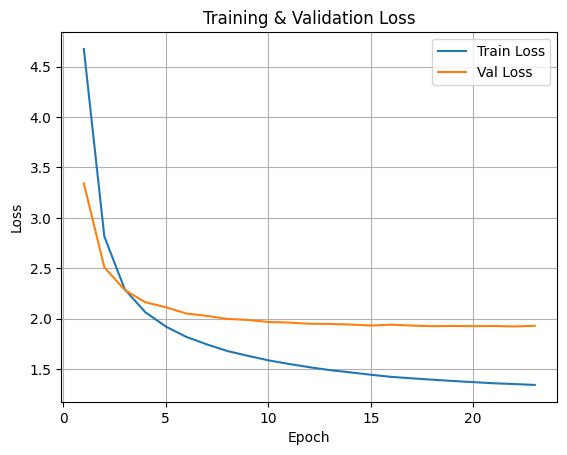

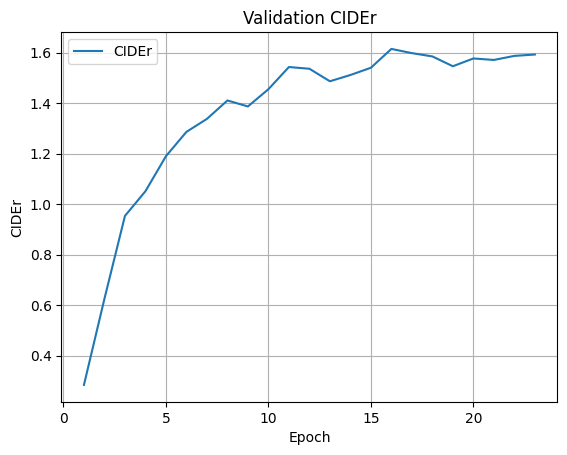

In [12]:
num_epochs = 30
patience = 7
best_cider = 0.0
save_path = "captioner_rsicd_best.pt"
epochs_no_improve = 0
train_losses = []
val_losses = []
ciders = []
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Validation: chỉ eval 500 samples để nhanh
    val_loss, bleu4, cider = evaluate(model, val_loader, tokenizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    ciders.append(cider)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, BLEU-4: {bleu4*100:.2f}, CIDEr: {cider:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}")

    scheduler.step()

    # Save best model by CIDEr
    if cider > best_cider:
        best_cider = cider
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'cider': cider,
            'bleu4': bleu4,
        }, save_path)
        print(f"Saved best model (CIDEr: {cider:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

print("\n" + "="*50)
print("Training completed!")
print(f"Best CIDEr: {best_cider:.4f}")
plot_loss_curve(train_losses, val_losses)
plot_cider_curve(ciders)

In [13]:
# Load best model
checkpoint = torch.load(save_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"  - Validation CIDEr: {checkpoint['cider']:.4f}")
print(f"  - Validation BLEU-4: {checkpoint['bleu4']*100:.2f}\n")

# Test với ALL samples và ALL metrics
test_results, test_refs, test_hyps = test_evaluation(model, test_loader, tokenizer, device)

print("\n" + "="*50)
print("TEST RESULTS:")
print("="*50)
print(f"Number of test samples: {test_results['num_samples']}")
print(f"Loss: {test_results['loss']:.4f}\n")
print("Scores:")
print(f"  BLEU-1:  {test_results['BLEU_1']*100:6.2f}")
print(f"  BLEU-2:  {test_results['BLEU_2']*100:6.2f}")
print(f"  BLEU-3:  {test_results['BLEU_3']*100:6.2f}")
print(f"  BLEU-4:  {test_results['BLEU_4']*100:6.2f}")
print(f"  METEOR:  {test_results['METEOR']*100:6.2f}")
print(f"  ROUGE-L: {test_results['ROUGE_L']*100:6.2f}")
print(f"  CIDEr:   {test_results['CIDEr']:6.4f}")
if test_results['SPICE'] is not None:
    print(f"  SPICE:   {test_results['SPICE']*100:6.2f}")
print("="*50)

Loaded best model from epoch 16
  - Validation CIDEr: 1.6143
  - Validation BLEU-4: 40.24

Generating captions for test set...


Test: 100%|██████████| 18/18 [02:52<00:00,  9.58s/it]



Computing metrics...
  - Computing BLEU scores...
{'testlen': 11420, 'reflen': 11826, 'guess': [11420, 10327, 9234, 8141], 'correct': [6639, 2802, 1421, 736]}
ratio: 0.9656688652121626
  - Computing METEOR...
  - Computing ROUGE-L...
  - Computing CIDEr...
  - Computing SPICE...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
  - SPICE not available: Command '['java', '-jar', '-Xmx8G', 'spice-1.0.jar', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/tmp/tmp0trbdxop', '-cache', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/cache', '-out', '/usr/local/lib/python3.12/dist-packages/pycocoevalcap/spice/tmp/tmpg6mzz659', '-subset', '-silent']' returned non-zero exit status 1.

TEST RESULTS:
Number of test samples: 1093
Loss: 2.5982

Scores:
  BLEU-1:   56.10
  BLEU-2:   38.33
  BLEU-3:   27.94
  BLEU-4:   20.89
  METEOR:   26.72
  ROUGE-L:  40.14
  CIDEr:   0.4588



Visualizing random examples...

Saved visualization to 'test_predictions.png'


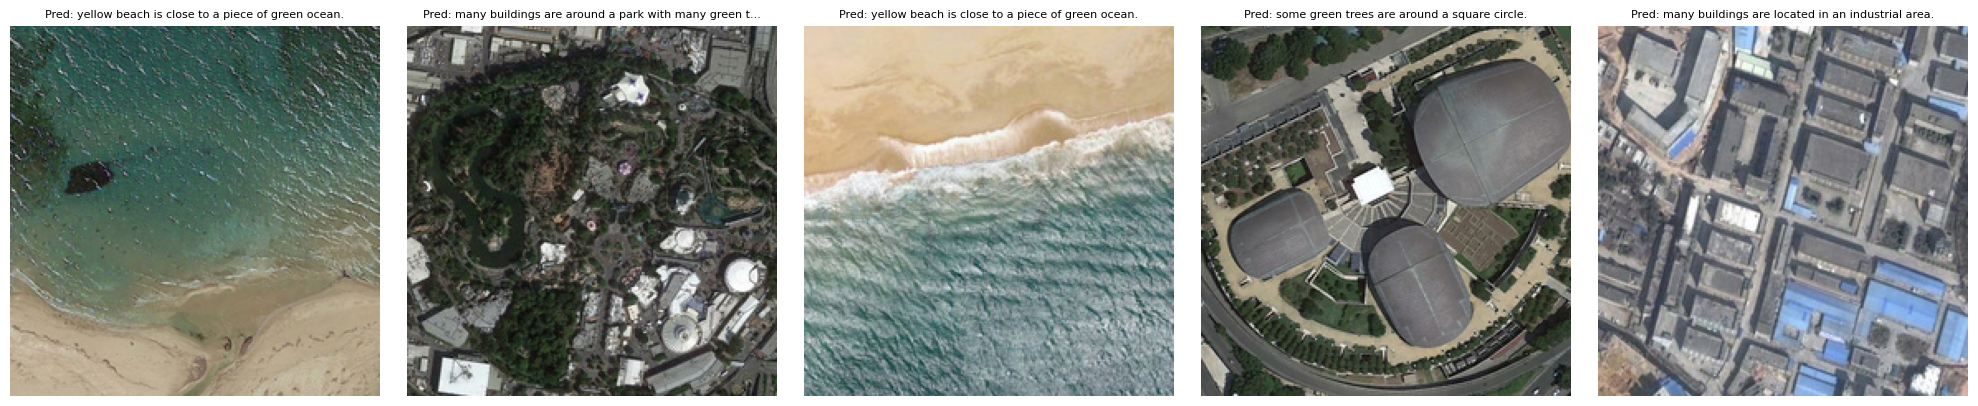


Saved predictions to 'test_predictions.json'


In [14]:
import matplotlib.pyplot as plt

def visualize_predictions(refs, hyps, dataset, num_examples=5):
    """Visualize some prediction examples"""
    indices = random.sample(range(len(refs)), min(num_examples, len(refs)))

    fig, axes = plt.subplots(1, num_examples, figsize=(4*num_examples, 4))
    if num_examples == 1:
        axes = [axes]

    for ax_idx, img_idx in enumerate(indices):
        # Get image
        ex = dataset.data[img_idx]
        img_path = ex.get("image_path", ex.get("image"))
        if isinstance(img_path, str):
            image = Image.open(img_path).convert("RGB")
        else:
            image = ex["image"]
            if not isinstance(image, Image.Image):
                image = Image.fromarray(np.array(image))

        # Plot
        axes[ax_idx].imshow(image)
        axes[ax_idx].axis('off')

        # Title with prediction
        pred = hyps[img_idx][0]
        title = f"Pred: {pred[:50]}..." if len(pred) > 50 else f"Pred: {pred}"
        axes[ax_idx].set_title(title, fontsize=8, wrap=True)

    plt.tight_layout()
    plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
    print("\nSaved visualization to 'test_predictions.png'")
    plt.show()

print("\nVisualizing random examples...")
visualize_predictions(test_refs, test_hyps, test_data, num_examples=5)

# ============================================================================
# SAVE PREDICTIONS TO FILE
# ============================================================================
import json

output_file = 'test_predictions.json'
predictions = []
for idx in range(len(test_refs)):
    predictions.append({
        'image_id': idx,
        'ground_truth': test_refs[idx],
        'prediction': test_hyps[idx][0]
    })

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump({
        'metrics': {k: float(v) if v is not None else None for k, v in test_results.items()},
        'predictions': predictions[:100]  # Save first 100 examples
    }, f, indent=2, ensure_ascii=False)

print(f"\nSaved predictions to '{output_file}'")